In [1]:
!nvidia-smi

Tue Jul  9 17:07:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.92                 Driver Version: 546.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8               7W / 124W |   1792MiB / 12282MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import relevant modules

# Import modules for vector calculations
import numpy as np
import scipy as sp
import pandas as pd
import scipy.linalg as la
import scipy.optimize as opt

# Import modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
%matplotlib inline

# Import modules for file handling 
import os
import io
import sys
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tifffile import imread, imsave
from skimage import io, measure
import time

# Import modules for Deep Learning
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchsummary import summary
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
torch.set_float32_matmul_precision("medium|high")

# Import custom modules
from Gap_UNetResblock import UNet
from GAPUNet import GAPUNet
from BinomDataset2 import BinomDataset

In [3]:
# Using the GPU for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
Data = np.concatenate((imread(r'trainingDataGT.tif'), imread(r'testDataGT.tif')))

(2048, 512, 512)


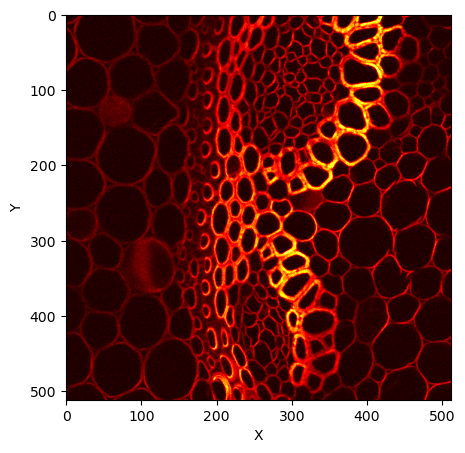

In [5]:
# Review the Dataset
plt.figure(figsize=(5,5))
plt.imshow(Data[2000], cmap='hot')
print(Data.shape)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [6]:
def psnrToString(inp):
    if inp < 0:
        return "m"+str(-inp)
    else:
        return str(inp)
    
# We set the pseudo PSNR range used for splitting the images into input and target
minpsnr = -40
maxpsnr = -5

name = psnrToString(minpsnr) + "to" + psnrToString(maxpsnr) + "-256x256"
CHECKPOINT_PATH = "./models/" 

In [7]:
Train_Psnr_Distribution = torch.randint(torch.tensor([minpsnr]), torch.tensor([maxpsnr]), (round(Data.shape[0]*0.8),))
len(Train_Psnr_Distribution)

1638

In [8]:
Valid_Psnr_Distribution = torch.randint(torch.tensor([minpsnr]), torch.tensor([maxpsnr]), (round(Data.shape[0]*0.2,),))
len(Valid_Psnr_Distribution)

410

In [9]:
maxepochs = 20 # Train for longeer if needed

# Create the pytorch dataset
Train_Dataset = BinomDataset(Data[:round(Data.shape[0]*0.9)], 1, 256, minpsnr, maxpsnr, virtSize= 500 *32)
Valid_Dataset = BinomDataset(Data[round(Data.shape[0]*0.9):], 1, 256, minpsnr, maxpsnr)

# Create the Dataloaders for the training and validation sets
Train_Loader = DataLoader(Train_Dataset, batch_size = 32, shuffle = True, drop_last = True, pin_memory=False)
Validation_Loader = DataLoader(Valid_Dataset, batch_size = 32, shuffle = False, drop_last = True, pin_memory=False)

img_input, psnr_map, target_img  = next(iter(Train_Loader))
print("Image Input: ",img_input.shape)
print("Psnr_Map", psnr_map.shape)
print("target_img", target_img.shape)

# Define the callbacks for the model training and validation.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)


# Create the U-net model
in_channels = 1
levels = 10
depth = 6
start_filts = 28
up_mode = 'transpose'

Model = GAPUNet(in_channels = 1, intermediary_channels = 2, out_channels = 1, levels=10, depth=7,
                 start_filts=28, up_mode = 'transpose').to(device)


Image Input:  torch.Size([32, 1, 256, 256])
Psnr_Map torch.Size([32, 1, 256, 256])
target_img torch.Size([32, 1, 256, 256])


In [10]:
len(Train_Loader)

500

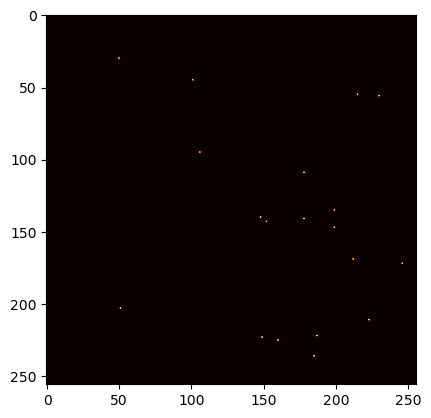

In [11]:
plt.imshow(img_input[10].detach().cpu().permute(1,2,0).squeeze(), cmap='hot')
plt.show()

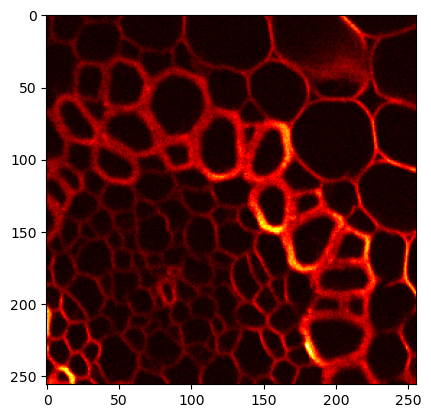

In [12]:
plt.imshow(target_img[10].detach().cpu().permute(1,2,0).squeeze(), cmap='hot')
plt.show()

In [13]:
Model.Auxilliary_Network.forward(img_input.to(device), psnr_map.to(device)).shape

torch.Size([32, 16, 256, 256])

In [14]:
Model.predict(img_input.to(device), psnr_map.to(device)).shape

torch.Size([32, 1, 256, 256])

In [17]:
len(Train_Loader)

500

In [18]:
Trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     accelerator= "gpu", devices = [0],
                     max_epochs=maxepochs, 
                     callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=25)])
Trainer.fit(Model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type              | Params
---------------------------------------------------------
0 | Auxilliary_Network | Auxiliary_Network | 700   
1 | UNet               | UNet              | 33.4 M
---------------------------------------------------------
33.4 M    Trainable params
0         Non-trainable params
33.4 M    Total params
133.783   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [19]:
Trainer.test(Model, Train_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -0.3074701130390167    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.3074701130390167}]

In [20]:
Trainer.test(Model, Validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -0.2121865451335907    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.2121865451335907}]

In [21]:
model = GAPUNet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [22]:
dataTest = imread(r'testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT = imread(r'testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

(512, 512)
-11.500555581049394
torch.Size([512, 512])


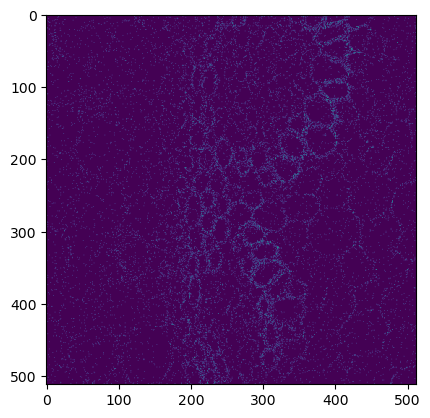

In [34]:
for inp, gt in zip(dataTest, dataTestGT):  
    print(inp.shape)
    Psnr = np.log10(inp.mean().item()+ 1e-50) *10
    Psnr = max(-40,Psnr)
    print(Psnr)
    Psnr = max(-40,Psnr)
    Psnr = torch.FloatTensor([Psnr]).to(device)
    Psnr_map = Psnr.unsqueeze(-1).expand(inp.shape).type(torch.float32)
    print(Psnr_map.shape)
    plt.imshow(inp)
    plt.show()
    break

332 0 44.3373404001294 272.0 17.0


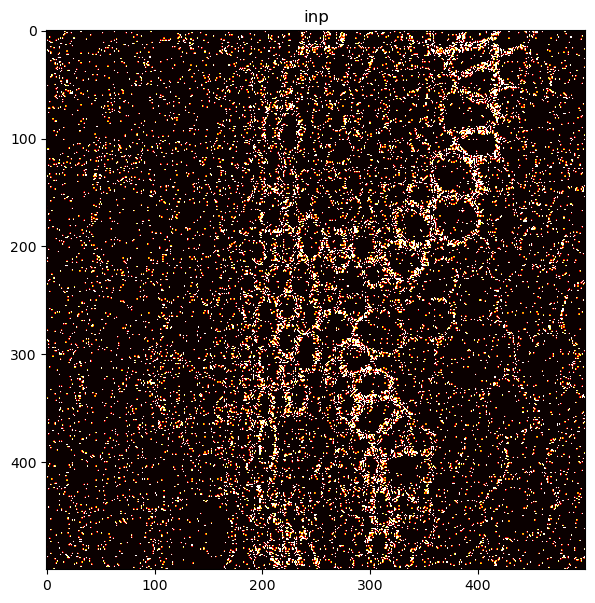

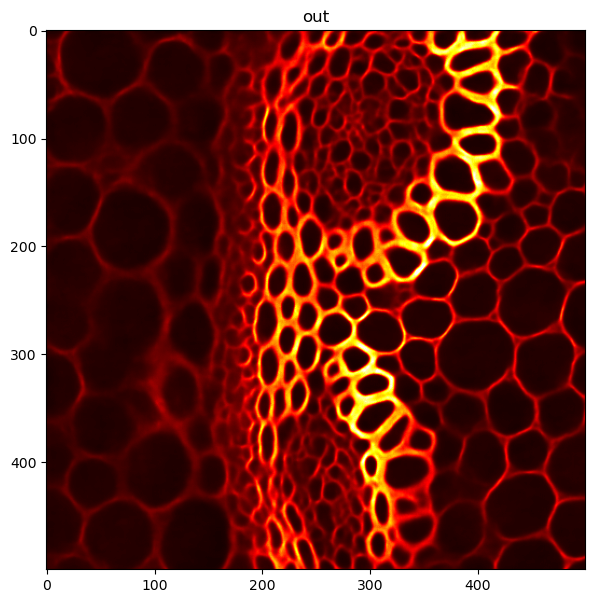

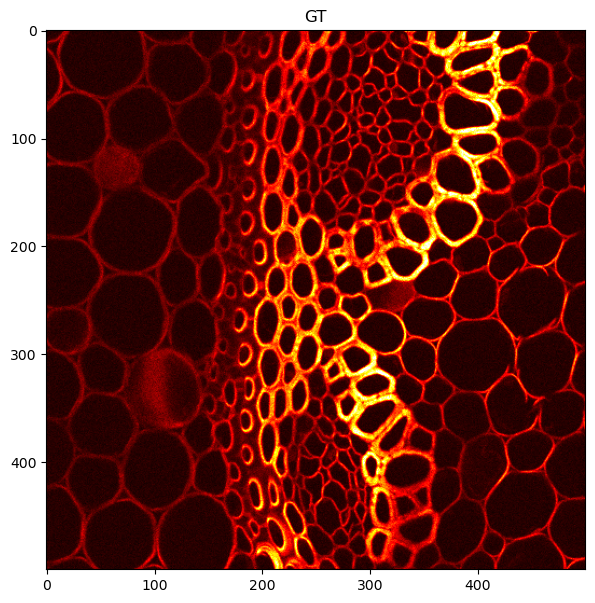

In [36]:
outputs = []
for inp, gt in zip(dataTest, dataTestGT):  
    inpT = torch.from_numpy(inp.astype(np.float32)).to(device)
    Psnr = np.log10(inpT.mean().item()+ 1e-50) *10
    Psnr = max(-40,Psnr)
    Psnr = torch.FloatTensor([Psnr]).to(device)
    Psnr_map = Psnr.unsqueeze(-1).expand(inpT.shape).type(torch.float32)
    # We have to apply softmax over pixels
    out = torch.exp(model(inpT[None,None,...], Psnr_map[None, None, ...]).detach().cpu())
    out = inp.sum() * out / out.sum()
    outputs.append(out.numpy()[0,0])
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))
    
    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99.9)
    
    plt.figure(figsize=(7,7))
    plt.imshow(inp[:500,:500],vmin = 0, vmax = vmax, cmap = "hot")
    plt.title('inp')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,0][:500,:500],vmin = 0,vmax = vmax, cmap = "hot")
    plt.title('out')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(gt[:500,:500],vmin = 0,vmax = vmax, cmap = "hot")
    plt.title('GT')

In [37]:
outputs = np.array(outputs)
imsave(r'output.tif',outputs, imagej = True)

In [60]:
def sample_imaging(input_image,
                 model,
                 max_photons = None,
                 max_its = 500000,
                 max_psnr = -15,
                 save_every_n = 5,
                 beta = 0.1
                ):

    start = input_image.clone()
    photons = start
    photnum = 1

    denoised = None
    stack = []
    
    sumDenoised = start
    region = 64
    
    for i in range(max_its):
        #print("index",i)
        # compute the pseudo PSNR
        psnr = np.log10(photons.mean().item() + 1e-50) * 10
        psnr = max(-40, psnr)
        Psnr = torch.FloatTensor([psnr]).to(device)
        Psnr_map = Psnr.unsqueeze(-1).unsqueeze(-1).expand(input_image.shape).type(torch.float32)
        
            
        if (max_photons is not None) and (photons.sum().item() > max_photons):
            break
            
        if psnr > max_psnr:
            break
    
        #print(photons.shape)
        denoised = model(photons, Psnr_map).detach()
        #print(denoised.shape)
        denoised = denoised - denoised.max()
        denoised = torch.exp(denoised)   
        denoised = denoised / (denoised.sum(dim=(-1,-2,-3), keepdim = True))
        

        # here we save an image into our stack
        if (save_every_n is not None) and (i%save_every_n == 0):  

            imgsave = denoised[0,0,:,...].detach().cpu()
            imgsave = imgsave/imgsave.max()
            photsave = photons[0,0,:,...].detach().cpu()
            photsave = photsave / max(photsave.max(),1)      
            combi = torch.cat((photsave,imgsave),1)
            stack.append(combi.numpy())

        # increase photon number
        photnum = max(beta* photons.sum(),1)
        
        # draw new photons
        new_photons = torch.poisson(denoised*(photnum)) 
        
        # add new photons
        photons = photons + new_photons 
        
    
    return denoised[...].detach().cpu().numpy(), photons[...].detach().cpu().numpy(), stack, i

-500.0
-48.16479930623699
-48.16479930623699
-45.15449934959718
-42.14419939295737
-41.175099262876806
-41.175099262876806
-40.383286802400555
-39.713818906094424
-39.713818906094424
-38.62237421184374
-37.75087245465474
-37.75087245465474
-37.37298684576074
-37.37298684576074
-37.025365783168624
-37.025365783168624
-36.70351894945461
-35.86031009245425
-35.86031009245425
-35.61207425520393
-35.61207425520393
-35.15449934959718
-35.15449934959718
-34.9426063588978
-34.9426063588978
-34.74057249801493
-34.54752094606106
-34.54752094606106
-34.36268688912093
-34.36268688912093
-34.01506582652881
-33.54081932724743
-33.11329952303793
-32.850010135814436
-32.601774298564116
-32.36696334006889
-32.36696334006889
-32.36696334006889
-32.254153235972
-31.93230640225799
-31.73027254137512
-31.632674168483558
-31.35238693248112
-31.175099262876806
-31.08909754525763
-30.840861708007306
-30.530519370607617
-30.45627918981555
-30.171393811701176
-29.904051279228728
-29.591474341924307
-29.41418667

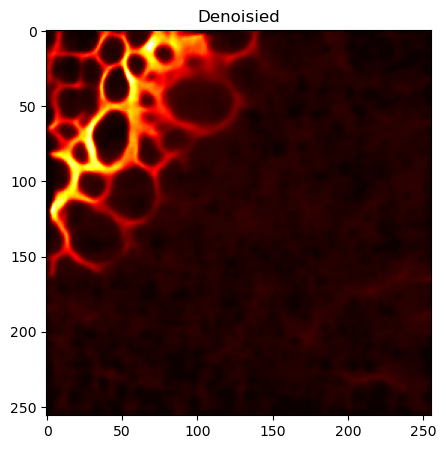

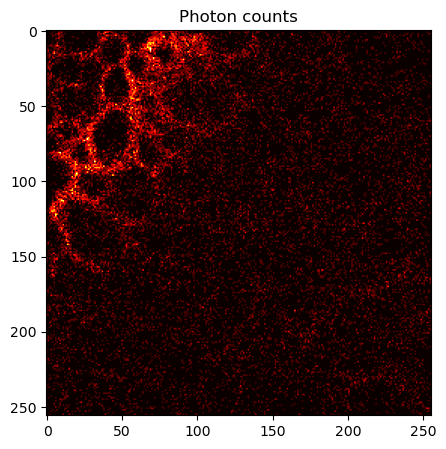

_______________________________________ 166
time (s): 1.1885690689086914 time per image (s) 1.1885690689086914


In [68]:

import matplotlib.image as mpimg
import time
import numpy as np
from Inference import sample_image

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 256
pixels_y = 256

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x).to(device)


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    #print(inp_img.shape)
    denoised, photons, stack, iterations = sample_imaging(inp_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = -5)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
            print(iterations)

            #print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], cmap='hot', vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Denoisied')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], cmap='hot', vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])

0


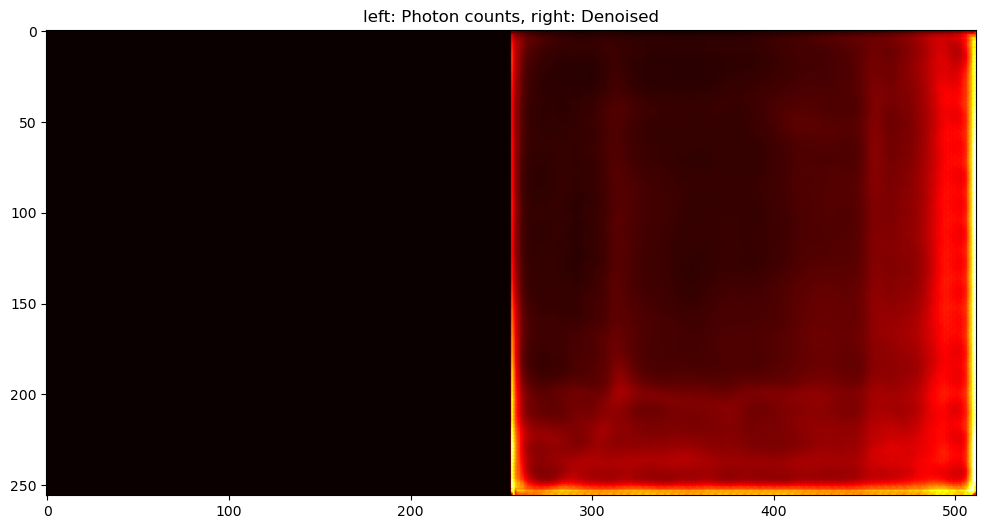

1


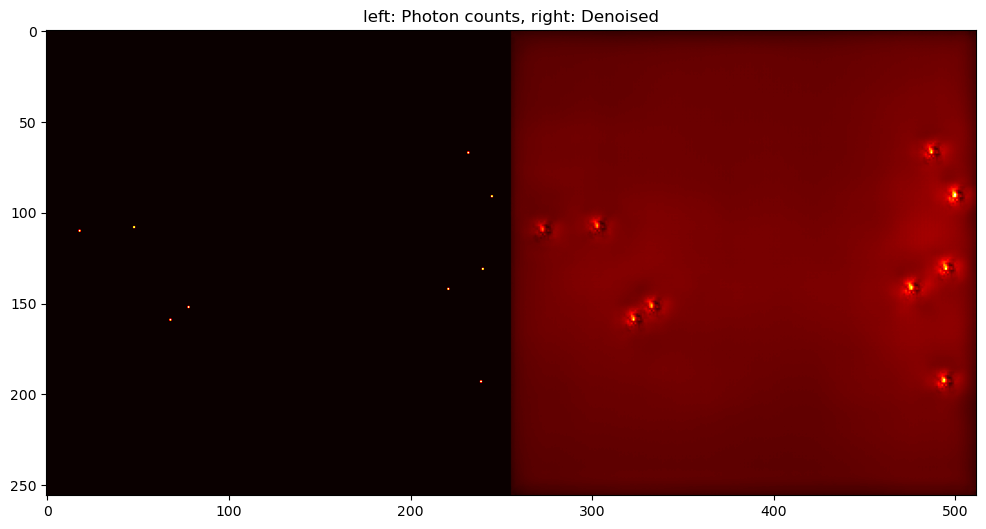

2


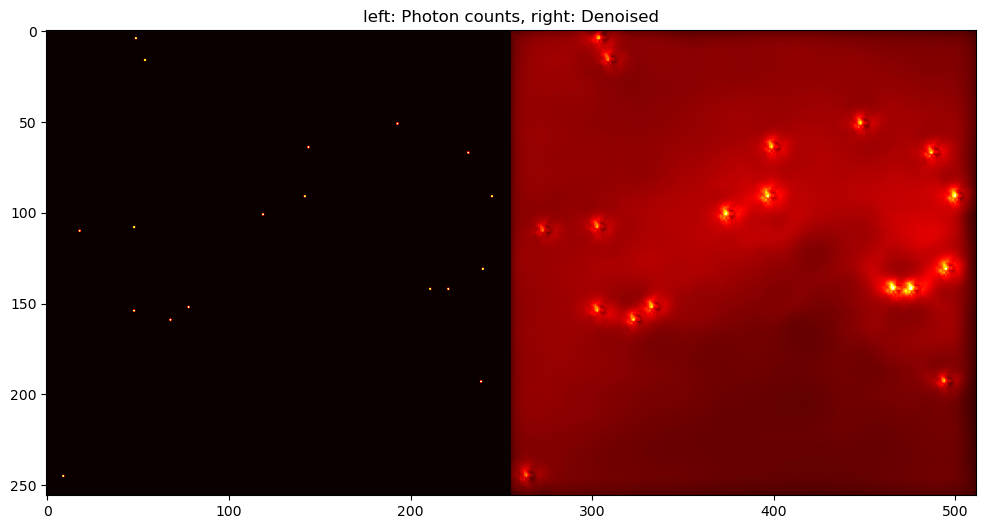

3


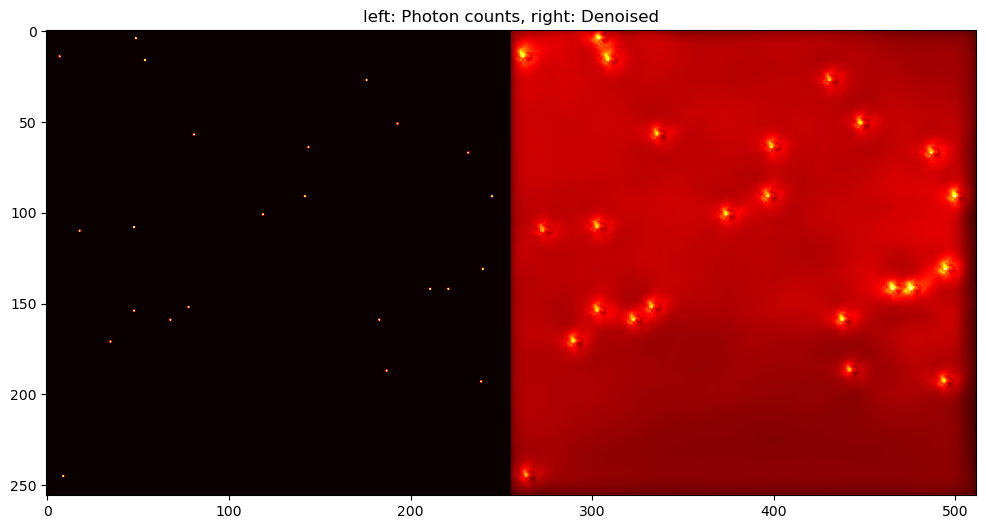

4


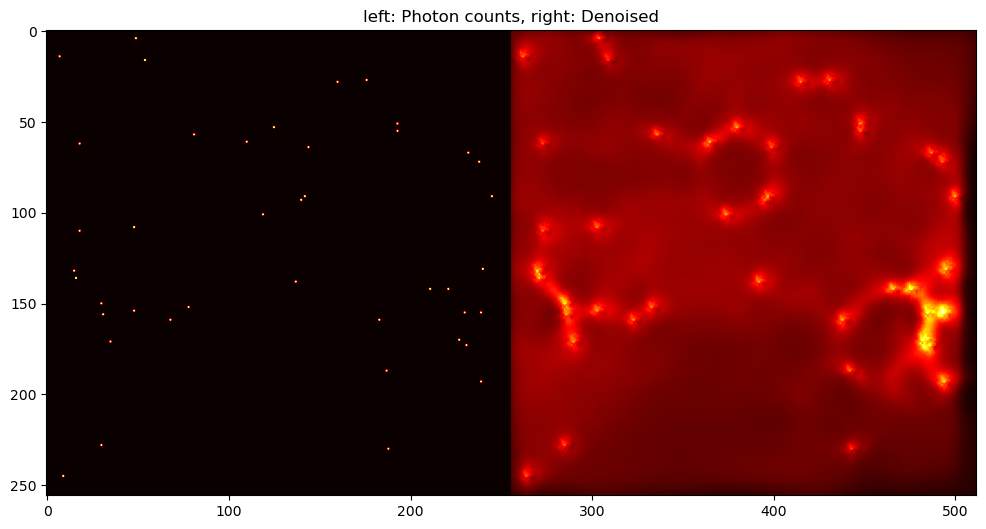

5


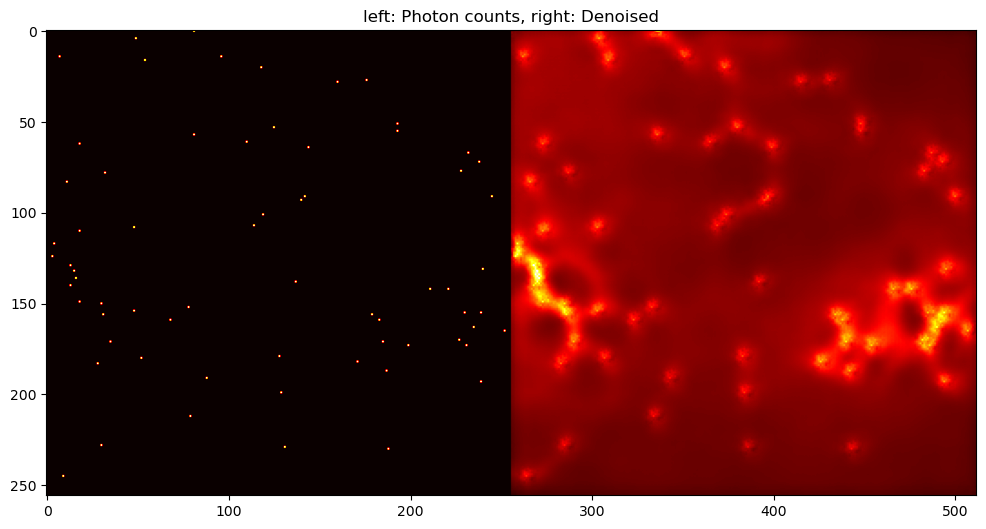

6


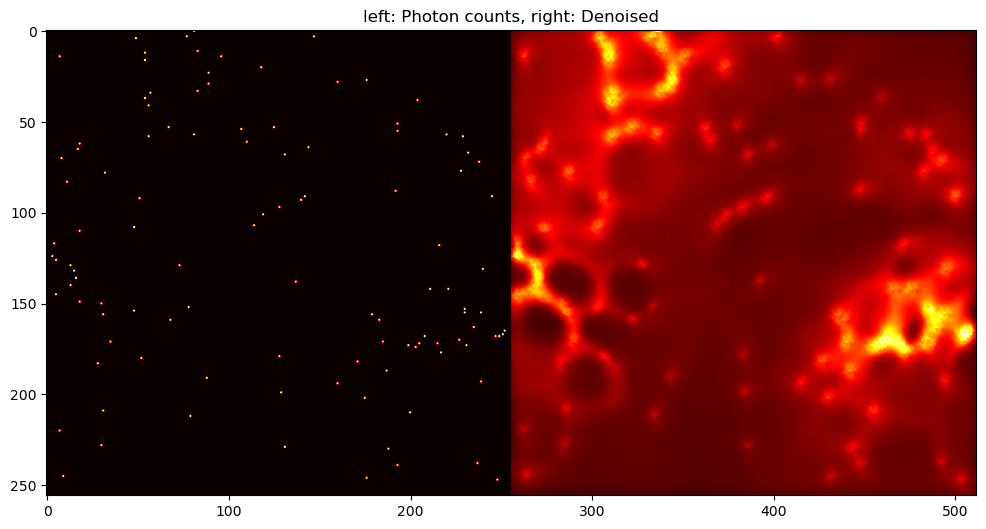

7


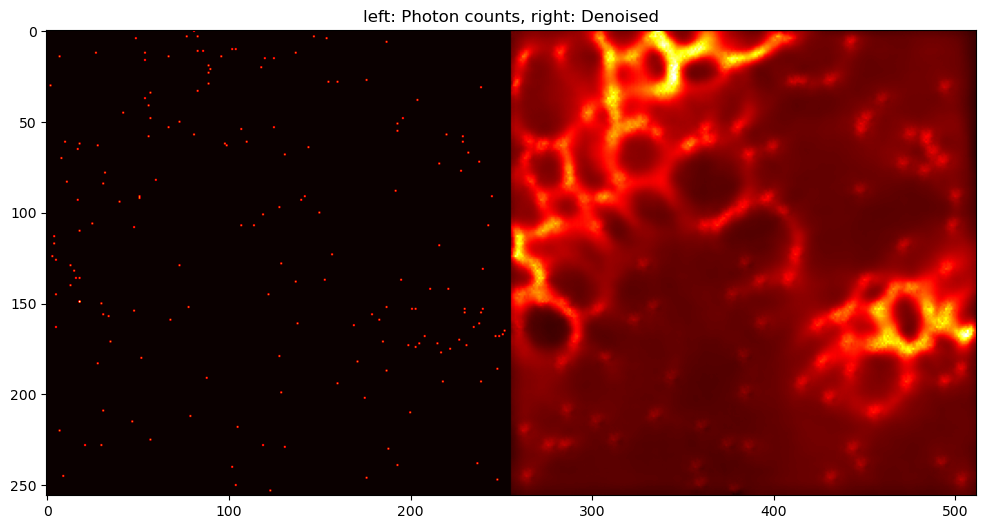

8


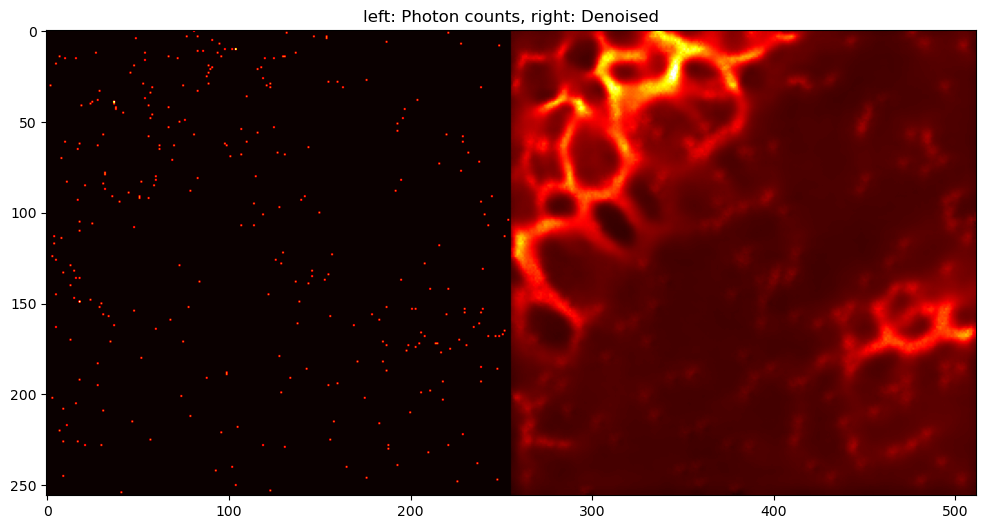

9


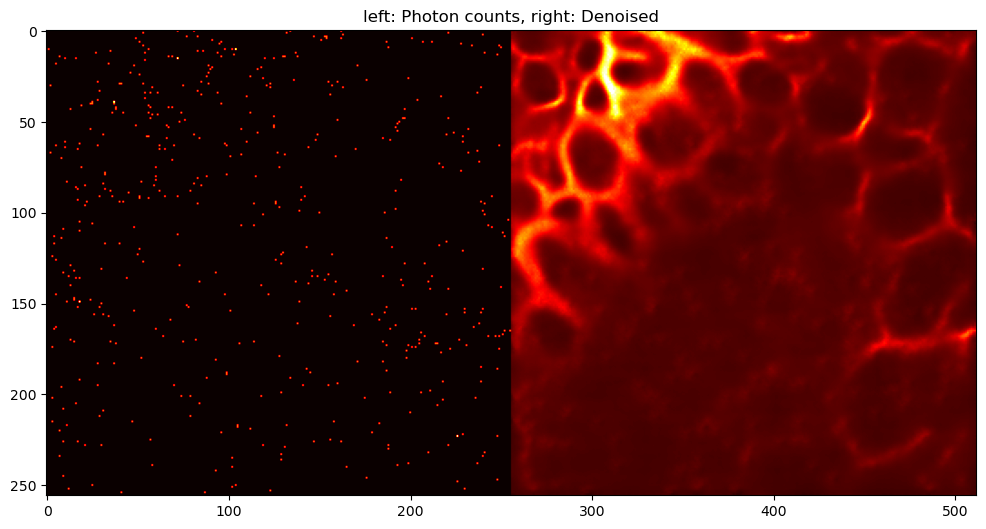

10


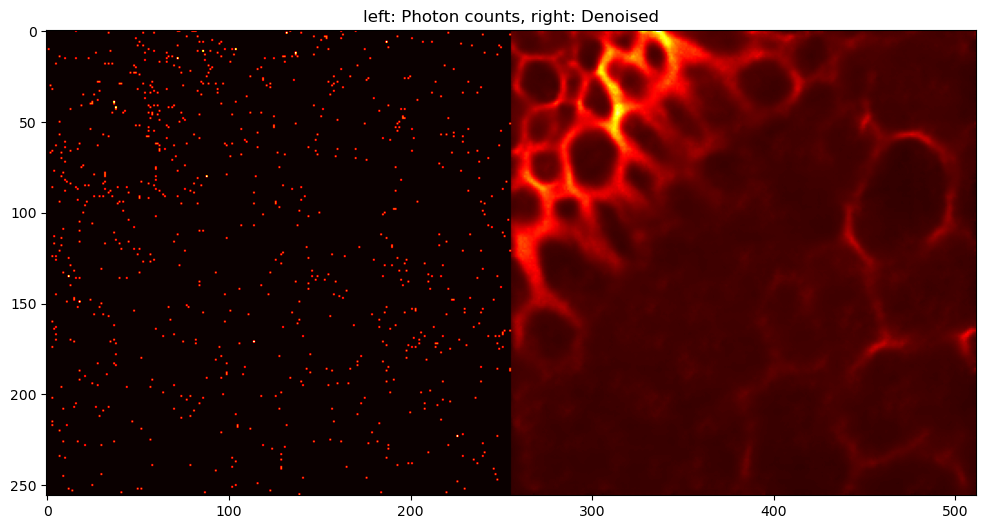

11


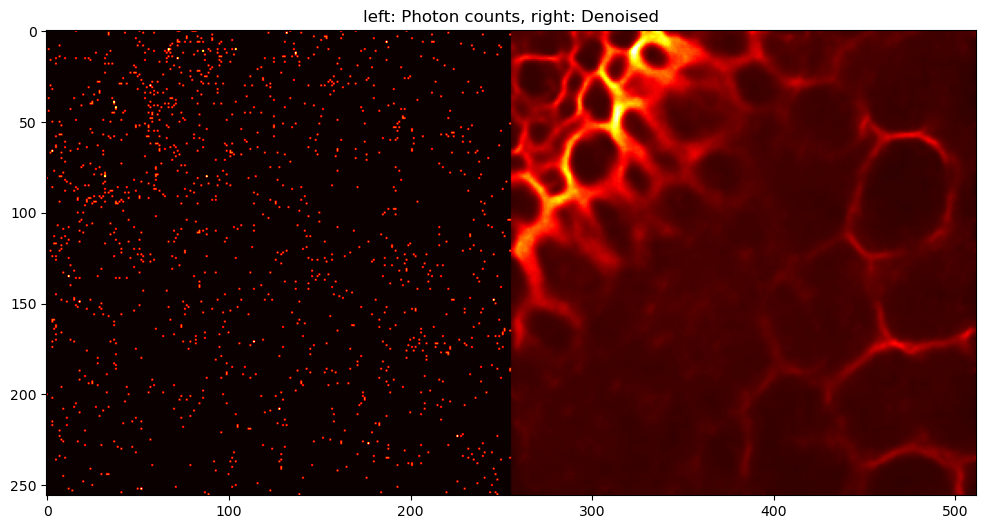

12


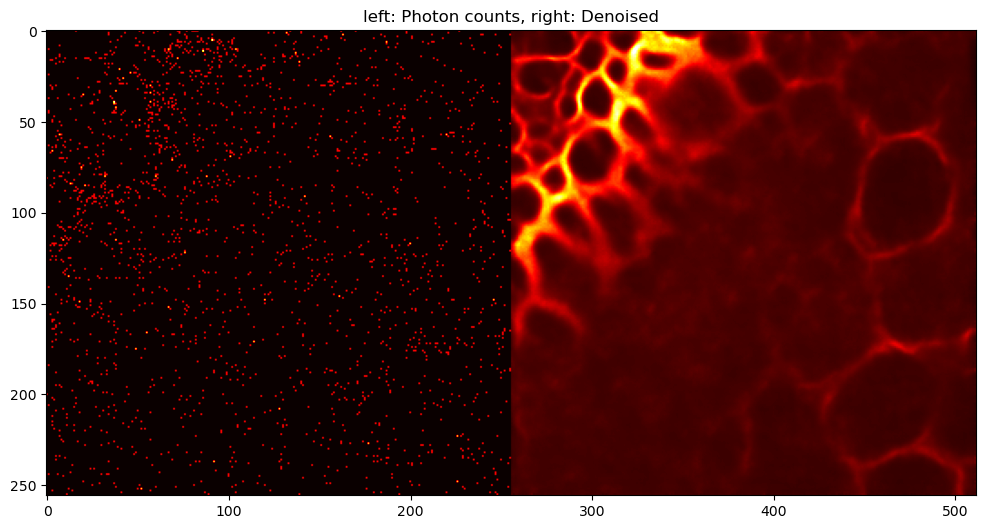

13


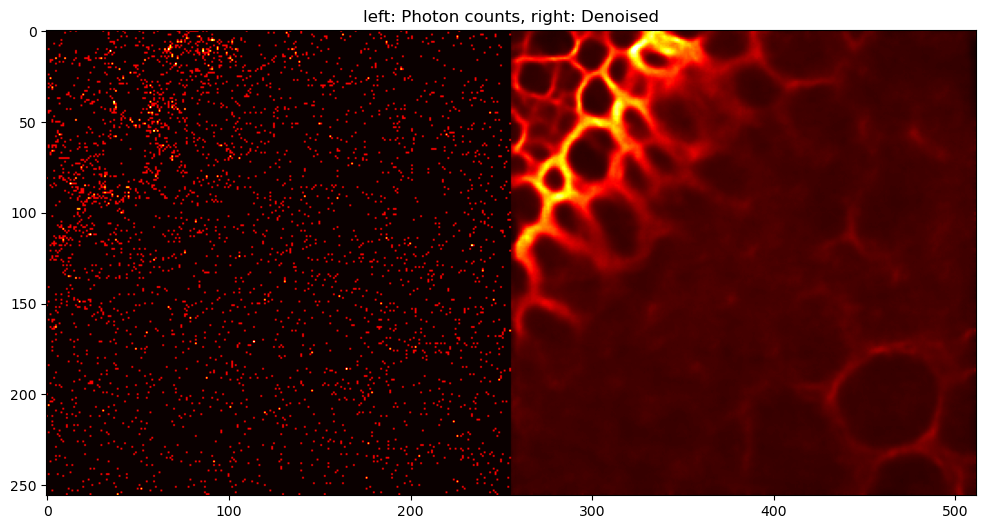

14


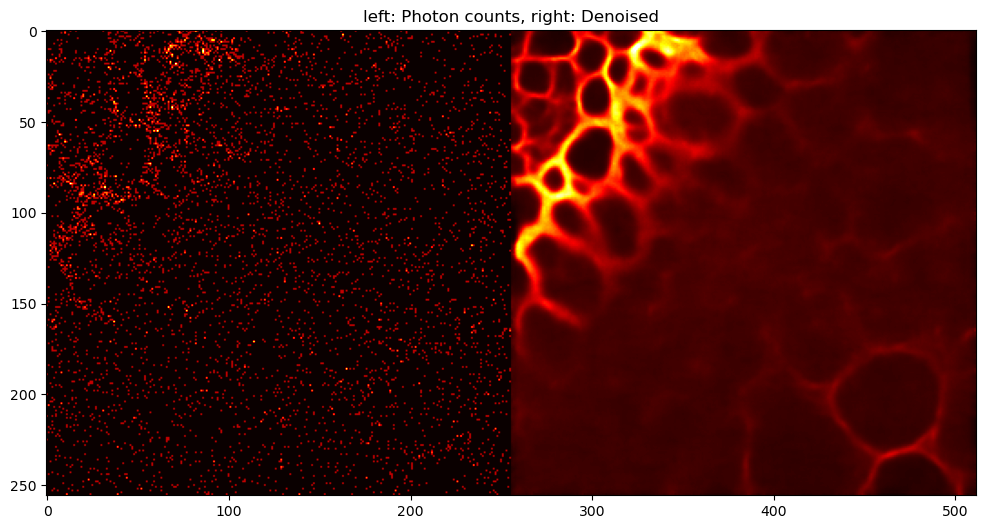

15


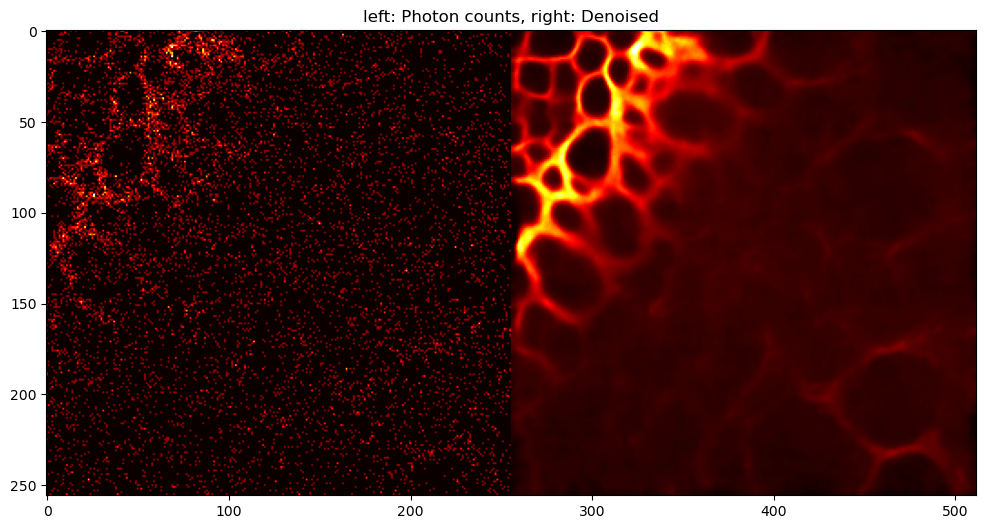

16


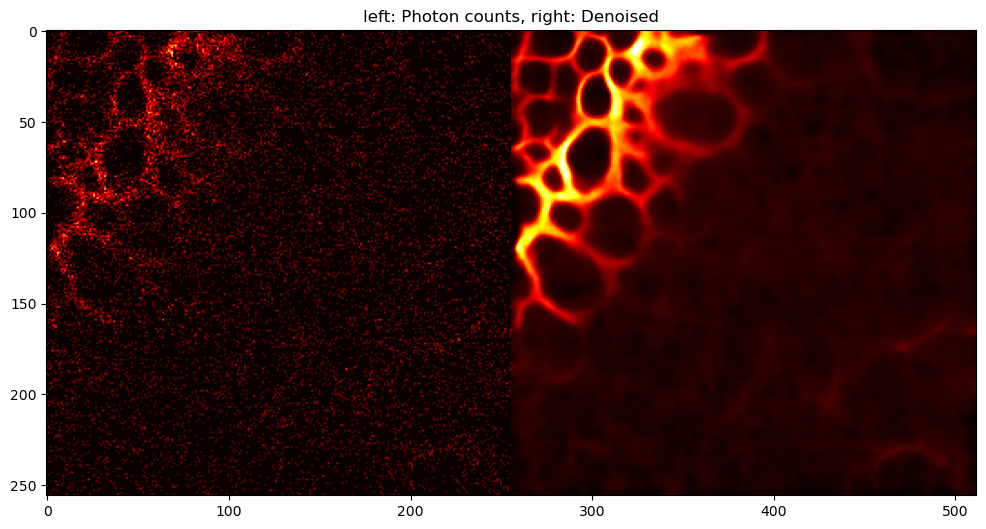

In [69]:
stack[0].shape
for i in range(len(stack)):
    im = stack[i]
    print(i)
    plt.figure(figsize = (12,12))
    plt.imshow(im,cmap ='hot', vmax = 0.9)
    plt.title('left: Photon counts, right: Denoised')
    plt.show()